# VN30 prediction by SARIMA

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [ ]:
# Load data
df = pd.read_csv('/content/Dữ liệu Lịch sử VN 30.csv')
df

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,29/09/2023,"1,166.26","1,169.26","1,176.77","1,165.15",144.90K,0.16%
1,28/09/2023,"1,164.45","1,167.96","1,168.09","1,144.47",193.65K,-0.36%
2,27/09/2023,"1,168.60","1,154.54","1,168.60","1,141.09",190.47K,1.32%
3,26/09/2023,"1,153.37","1,161.62","1,174.24","1,152.44",242.76K,-0.57%
4,25/09/2023,"1,159.94","1,195.36","1,199.65","1,159.94",263.86K,-3.15%
...,...,...,...,...,...,...,...
3673,09/01/2009,312.90,312.90,312.90,312.90,NaN,-0.39%
3674,08/01/2009,314.14,314.14,314.14,314.14,NaN,-1.99%
3675,07/01/2009,320.53,320.53,320.53,320.53,NaN,2.01%
3676,06/01/2009,314.21,314.21,314.21,314.21,NaN,0.96%


In [ ]:
  df.rename(columns={'Ngày': 'Time'}, inplace=True)
  df['Time'] = pd.to_datetime(df['Time'], format='%d/%m/%Y')
  df.index = df['Time']
  df.drop(["Time"], axis='columns', inplace=True)
  df.sort_index(ascending=True, inplace=True)
  df.drop(columns=['KL', '% Thay đổi'], inplace=True)
  df.rename(columns={'Lần cuối': 'Close', 'Mở': 'Open', 'Cao': 'High', 'Thấp': 'Low'}, inplace=True)
  df['Close'] = pd.to_numeric(df['Close'].str.replace(',', ''), errors='coerce')
  df['Open'] = pd.to_numeric(df['Open'].str.replace(',', ''), errors='coerce')
  df['High'] = pd.to_numeric(df['High'].str.replace(',', ''), errors='coerce')
  df['Low'] = pd.to_numeric(df['Low'].str.replace(',', ''), errors='coerce')

In [ ]:
df

,Close,Open,High,Low
Time,,,,
2009-01-05,311.23,311.23,311.23,311.23
2009-01-06,314.21,314.21,314.21,314.21
2009-01-07,320.53,320.53,320.53,320.53
2009-01-08,314.14,314.14,314.14,314.14
2009-01-09,312.90,312.90,312.90,312.90
...,...,...,...,...
2023-09-25,1159.94,1195.36,1199.65,1159.94
2023-09-26,1153.37,1161.62,1174.24,1152.44
2023-09-27,1168.60,1154.54,1168.60,1141.09


In [ ]:
print(df.dtypes)

Close    float64
Open     float64
High     float64
Low      float64
dtype: object


In [ ]:
# Resampling to daily frequency
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

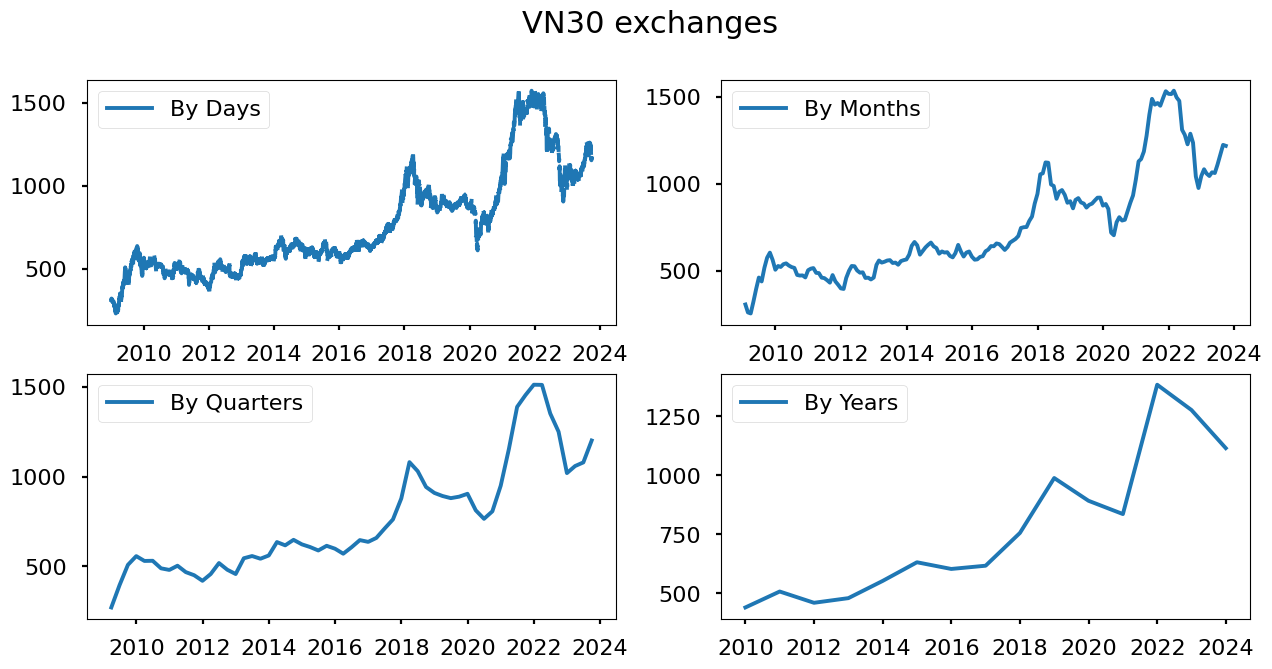

In [ ]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('VN30 exchanges', fontsize=22)

plt.subplot(221)
plt.plot(df['Close'], '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month['Close'], '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q['Close'], '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year['Close'], '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

**We will predict VN30 by months**

In [ ]:
df_month

,Close,Open,High,Low
Time,,,,
2009-01-31,307.423333,307.423333,307.423333,307.423333
2009-02-28,262.005000,262.005000,262.005000,262.005000
2009-03-31,256.123636,256.123636,256.123636,256.123636
2009-04-30,322.769500,322.769500,322.769500,322.769500
2009-05-31,397.122500,397.122500,397.122500,397.122500
...,...,...,...,...
2023-05-31,1061.515500,1062.102000,1066.423500,1057.077500
2023-06-30,1109.795909,1109.360455,1114.875909,1103.294545
2023-07-31,1165.240000,1162.381905,1167.882381,1157.314286


# Stationarity check and STL-decomposition of the series

Dickey–Fuller test: p=0.584385


<Figure size 1500x700 with 0 Axes>

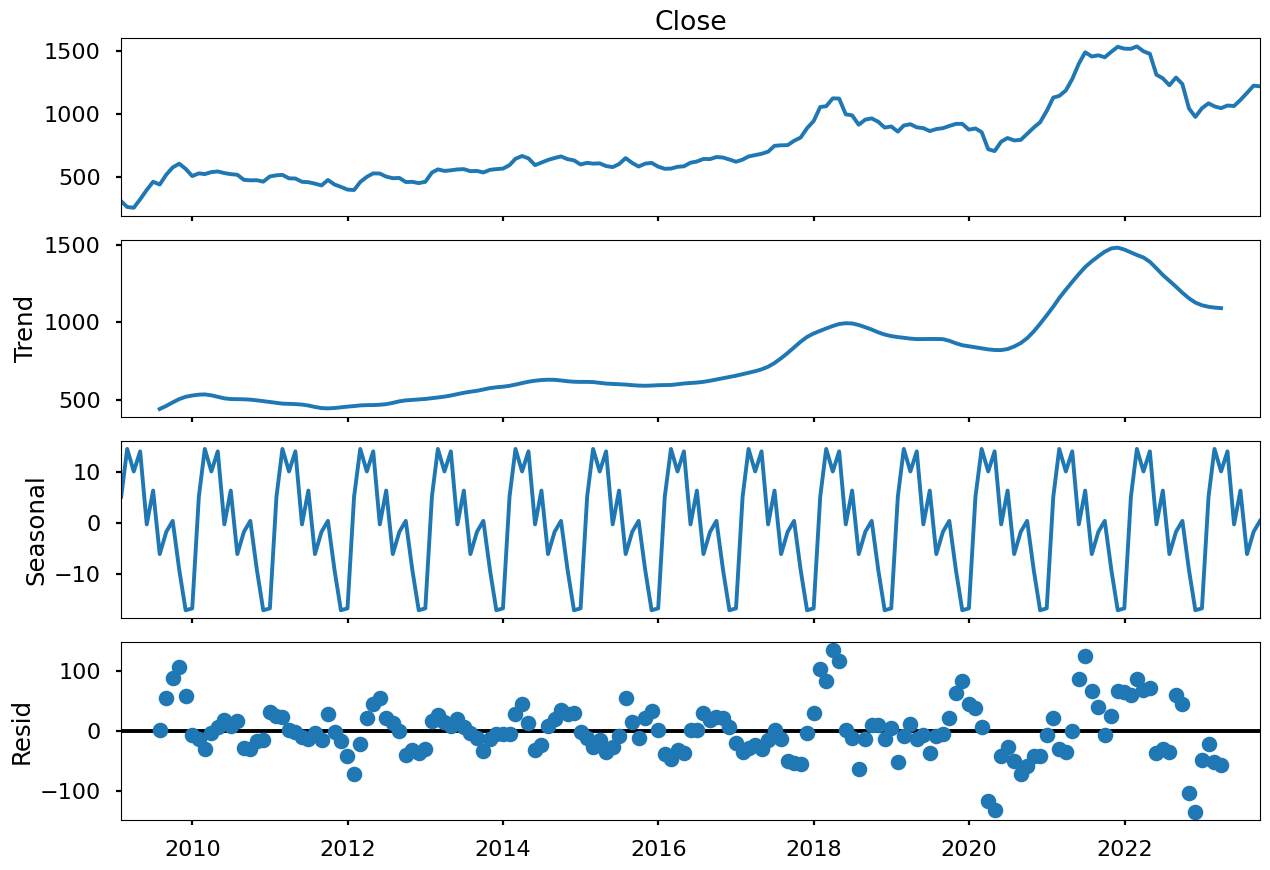

In [ ]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Close).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])
plt.show()

**The series are not stationary**

# Box-Cox Transformations


In [ ]:
# Box-Cox Transformations
df_month['Close_Price_box'], lmbda = stats.boxcox(df_month.Close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])

Dickey–Fuller test: p=0.584385


**The series are not stationary**

# Seasonal differentiation

Dickey–Fuller test: p=0.000399


<Figure size 1500x700 with 0 Axes>

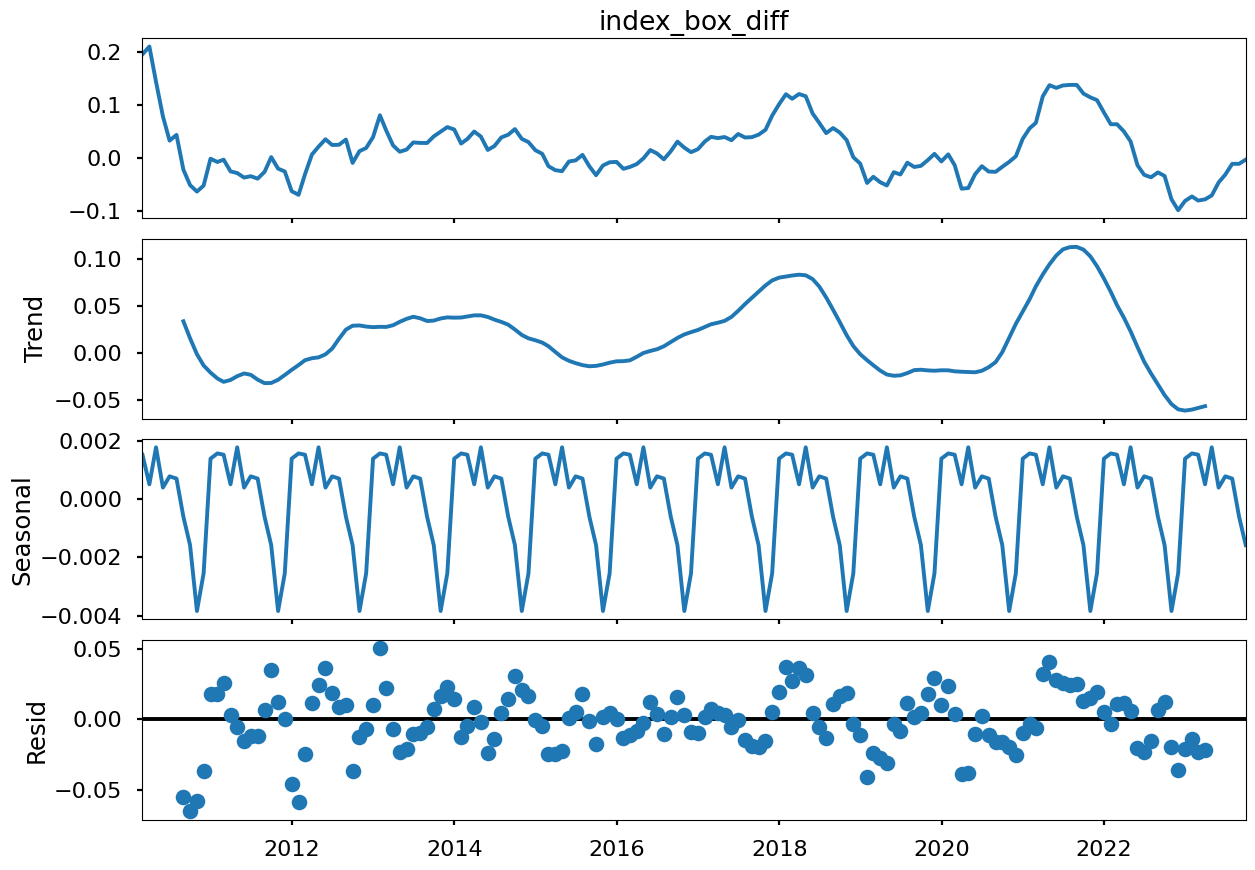

In [ ]:
# Seasonal differentiation
df_month['index_box_diff'] = df_month.Close_Price_box - df_month.Close_Price_box.shift(12)
plt.figure(figsize=(15,7))

sm.tsa.seasonal_decompose(df_month.index_box_diff[13:]).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.index_box_diff[12:])[1])

plt.show()

**The series are stationary => The series demonstrates annual seasonality => Using SARIMA**

# Model Selection

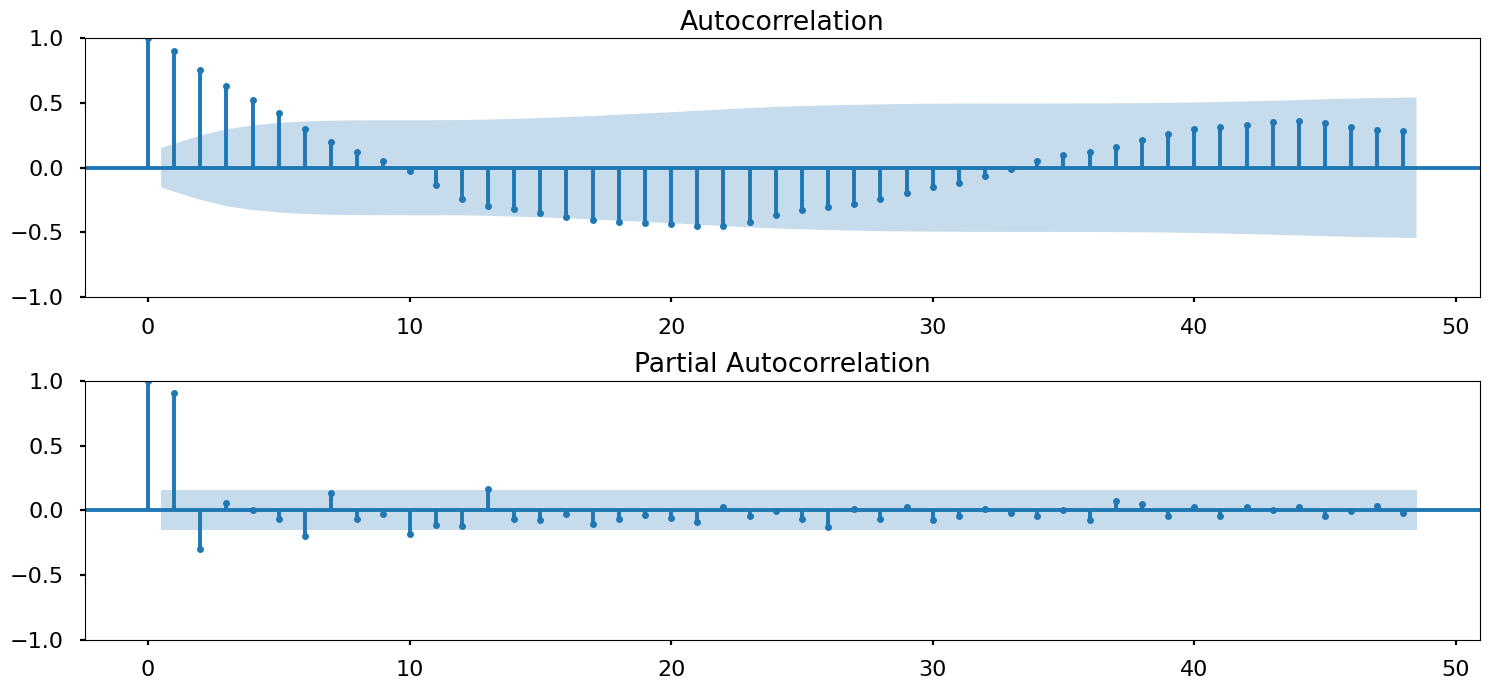

In [ ]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.index_box_diff[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.index_box_diff[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
df_month

,Close,Open,High,Low,Close_Price_box,index_box_diff
Time,,,,,,
2009-01-31,307.423333,307.423333,307.423333,307.423333,3.299723,NaN
2009-02-28,262.005000,262.005000,262.005000,262.005000,3.252048,NaN
2009-03-31,256.123636,256.123636,256.123636,256.123636,3.245144,NaN
2009-04-30,322.769500,322.769500,322.769500,322.769500,3.313929,NaN
2009-05-31,397.122500,397.122500,397.122500,397.122500,3.372754,NaN
...,...,...,...,...,...,...
2023-05-31,1061.515500,1062.102000,1066.423500,1057.077500,3.618782,-0.046127
2023-06-30,1109.795909,1109.360455,1114.875909,1103.294545,3.628733,-0.031365
2023-07-31,1165.240000,1162.381905,1167.882381,1157.314286,3.639532,-0.011150


In [ ]:
df_month_train = df_month['2009-01-31':'2021-01-31']
df_month_test = df_month['2021-01-31':'2023-09-30']

In [ ]:
# Initial approximation of parameters
Qs = range(0, 5)
qs = range(0, 5)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month_train.Close_Price_box, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic, model.bic, model.hqic])

In [ ]:
best_model=sm.tsa.statespace.SARIMAX(df_month_train.Close_Price_box, order=(2,1,2),seasonal_order=(0,1,3, 12)).fit(disp=-1)

In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic', 'bic', 'hqic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters         aic         bic        hqic
181  (2, 2, 0, 1) -699.817453 -682.520641 -692.788822
16   (0, 1, 0, 1) -698.152458 -689.504052 -694.638143
17   (0, 1, 0, 2) -697.940990 -686.409783 -693.255237
196  (2, 3, 0, 1) -697.874646 -677.695032 -689.674577
61   (0, 4, 0, 1) -697.868773 -680.571962 -690.840143


In [ ]:
print(best_model.summary())

                                         SARIMAX Results                                          
Dep. Variable:                            Close_Price_box   No. Observations:                  145
Model:             SARIMAX(2, 1, 2)x(0, 1, [1, 2, 3], 12)   Log Likelihood                 355.914
Date:                                    Thu, 14 Dec 2023   AIC                           -695.827
Time:                                            17:00:12   BIC                           -672.765
Sample:                                        01-31-2009   HQIC                          -686.456
                                             - 01-31-2021                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2568      0.342      0.750      0

# Prediction

In [ ]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

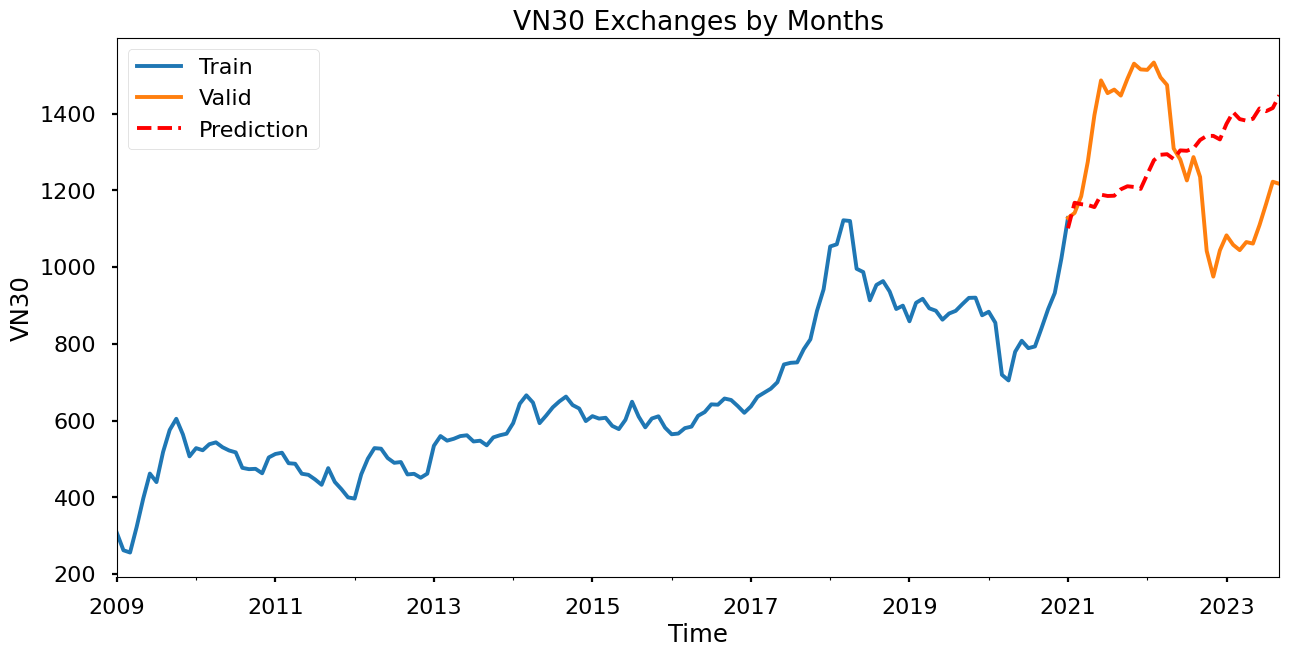

In [ ]:
# Prediction
df_month_target = df_month_train[['Close']]
last_date = df_month_target.index[-1]
date_list = pd.date_range(last_date, '2023-09-30', freq='M').tolist()
future = pd.DataFrame(index=date_list, columns=df_month_train.columns)
df_month_target = pd.concat([df_month_target, future])
end_point = len(df_month_target) - 1
df_month_target['forecast'] = invboxcox(best_model.predict(start=0, end=end_point), lmbda)

plt.figure(figsize=(15,7))
df_month_train.Close.plot(label='Train')
df_month_test.Close.plot(label='Valid')
df_month_target['2021-01-31':'2023-09-30'].forecast.plot(color='r', ls='--', label='Prediction')
plt.legend()
plt.title('VN30 Exchanges by Months')
plt.ylabel('VN30')
plt.show()

In [ ]:
targets = df_month_test.Close
targets.index.name = None
targets

2021-01-31    1128.167500
2021-02-28    1141.328000
2021-03-31    1184.748696
2021-04-30    1274.834000
2021-05-31    1396.133500
2021-06-30    1486.825000
2021-07-31    1453.654091
2021-08-31    1462.926364
2021-09-30    1447.267000
2021-10-31    1491.171429
2021-11-30    1530.529091
2021-12-31    1515.496957
2022-01-31    1514.280526
2022-02-28    1533.450625
2022-03-31    1494.911739
2022-04-30    1474.824500
2022-05-31    1309.351000
2022-06-30    1280.439091
2022-07-31    1226.057143
2022-08-31    1286.940000
2022-09-30    1235.261000
2022-10-31    1042.407143
2022-11-30     975.403636
2022-12-31    1043.924545
2023-01-31    1082.902500
2023-02-28    1058.397500
2023-03-31    1044.384348
2023-04-30    1065.473000
2023-05-31    1061.515500
2023-06-30    1109.795909
2023-07-31    1165.240000
2023-08-31    1222.701304
2023-09-30    1217.350526
Freq: M, Name: Close, dtype: float64

In [ ]:
preds = df_month_target['2021-01-31':'2023-09-30'].forecast
preds = preds.iloc[1:]
preds

2021-01-31    1101.321325
2021-02-28    1167.832447
2021-03-31    1164.179936
2021-04-30    1162.147383
2021-05-31    1156.588769
2021-06-30    1188.982232
2021-07-31    1185.605374
2021-08-31    1186.240158
2021-09-30    1202.960770
2021-10-31    1210.912900
2021-11-30    1209.083952
2021-12-31    1204.135897
2022-01-31    1241.751537
2022-02-28    1278.484537
2022-03-31    1292.976040
2022-04-30    1294.495754
2022-05-31    1281.950521
2022-06-30    1304.394212
2022-07-31    1303.396227
2022-08-31    1309.468587
2022-09-30    1331.447547
2022-10-31    1342.228845
2022-11-30    1342.244177
2022-12-31    1332.999526
2023-01-31    1373.542893
2023-02-28    1404.037788
2023-03-31    1385.895471
2023-04-30    1381.927250
2023-05-31    1386.744426
2023-06-30    1413.801103
2023-07-31    1406.714524
2023-08-31    1414.846485
2023-09-30    1447.956685
Name: forecast, dtype: float64

In [ ]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(preds, targets)
MAE

215.960969114391

In [ ]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(preds, targets)
MSE

59167.57788523389

In [ ]:
mape = np.sum(np.abs((targets - preds) / targets))*(100 / len(targets))
rmse = np.sqrt(mean_squared_error(targets, preds))

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse}")

MAPE: 17.47%
RMSE: 243.2438650515854
